#  Transformer-based object detection with HuggingFace

This notebook demonstrates object detection through transfomers using 'off-the-shelf' tool 'HuggingFace' (HF).
The dataset used is from our paper 'Strawberry picking point localization ripeness and weight estimation' published in ICRA 2022. The dataset was used to prepare a Detectron2 (Mask-RCNN) model for segmentation, classification (ripe, non-ripe), segmentation and keypoint (stem, top, left extreme, right extreme and bottom) estimation. The steps involved for object detection are:


1) Reformats the strawberry dataset jsons to HF format metadata.jsonl.
2) Creates HF dataset object
3) Creates functions for transformations (or agumentations) like resize, normalise etc.
4) Creates the train arguments and the train loop
5) Demonstrates a sample prediction


In [1]:
# Install required packages: assumes latest pytorch and other common scientific packages are installed
# datasets: prepare huggingface datsets format
# transformers: load transformer core
# evaluate: huggingface coco evaluation package
# timm: load pretrained DETR model
# albumentations: dataset transforms or augmentations
! pip install -q datasets transformers evaluate timm albumentations

In [2]:
import json
import jsonlines
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont
import shutil
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
# torch.set_grad_enabled(False);

from datasets import load_dataset

In [3]:
# not needed unless uploading model to huggingface hub
# will need huggingface account and git lfs installed
from huggingface_hub import notebook_login
notebook_login()

STEP 1: Reformat the strawberry dataset jsons to HF format metadata.jsonl.

In [4]:
DATA_DIR = '/home/bappadityadebnath/myprojects/aagi_final/datasets/' # parent dir
COCO_DATA_DIR = os.path.join(DATA_DIR, 'straw_db1_coco') # existing coco format json + imgs
HF_DATA_DIR = os.path.join(DATA_DIR, 'straw_db1') # hf format metadata.jsonl path + imgs
TRAIN_CHECKPOINT_DIR = '../checkpoints/detr-resnet-50_finetuned_sdb1_26_03_2204/'

# train checkpoint should not exists unless resume training
os.path.isdir(COCO_DATA_DIR), os.path.isdir(HF_DATA_DIR), \
os.path.isdir(TRAIN_CHECKPOINT_DIR)

(True, True, False)

In [5]:
# Read exsiting coco format json files
train_json = os.path.join(COCO_DATA_DIR, 'coco_train.json')
val_json = os.path.join(COCO_DATA_DIR, 'coco_val.json')

train_data = json.load(open(train_json))
val_data = json.load(open(val_json))

print('data_len', len(train_data), len(val_data))
train_data[3], val_data[4]

data_len 2249 100


({'image_id': 3,
  'image': '/data/aagi/data/sdb1_coco/train2017/2373.png',
  'width': 1008,
  'height': 756,
  'objects': {'id': [13, 14, 15, 16, 17],
   'bbox': [[341.5, 122, 571.5, 494.5],
    [143.5, 317, 256, 438.5],
    [531.5, 451, 636.5, 606.5],
    [739.5, 254, 829.5, 383.5],
    [578, 308, 619.5, 408.5]],
   'category': [0, 1, 1, 1, 1]}},
 {'image_id': 4,
  'image': '/data/aagi/data/sdb1_coco/val2017/404.png',
  'width': 1008,
  'height': 756,
  'objects': {'id': [15, 16, 17, 18, 19],
   'bbox': [[765, 412, 874.5, 527.5],
    [655.5, 373, 793.5, 601.5],
    [666.5, 509.5, 728.5, 594.5],
    [546.5, 272, 689.5, 461.5],
    [402.5, 190, 540.5, 355.5]],
   'category': [1, 0, 1, 0, 0]}})

In [6]:
def reformat(data, split) -> list:
    "reformat to hugging_face dataset format"
    reformatted_data = []
    object_id_count = 0
    for i in range(len(data)):
        reformatted_data.append({
            'image_id': data[i]['image_id'],
            # filname should be "train/<file_name>"
            'file_name': os.path.join(split, os.path.basename(data[i]['image'])),
            'objects': {
                'bbox': data[i]['objects']['bbox'],
                'categories': data[i]['objects']['category'],
            }
        })
    
    print('reformatted_data', len(reformatted_data))
    return reformatted_data

In [7]:
# save to huggingface metadata.jsonl. notice the 'l'
metadata = reformat(train_data, 'train')
metadata.extend(reformat(val_data, 'val'))

print('metadata', len(metadata))
print(metadata[3])

with jsonlines.open(os.path.join(HF_DATA_DIR, 'metadata.jsonl'), 'w') as writer:
    writer.write_all(metadata)
writer.close()

reformatted_data 2249
reformatted_data 100
metadata 2349
{'image_id': 3, 'file_name': 'train/2373.png', 'objects': {'bbox': [[341.5, 122, 571.5, 494.5], [143.5, 317, 256, 438.5], [531.5, 451, 636.5, 606.5], [739.5, 254, 829.5, 383.5], [578, 308, 619.5, 408.5]], 'categories': [0, 1, 1, 1, 1]}}


STEP 2) Creates HF dataset object

Folder structure required
path/to/dataset---metadata.jsonl
                  train/<train_images>
                  val/<validation_images>

In [8]:
# create the train and validation datasets sdb1
sdb1 = {}
sdb1['train'] = load_dataset("imagefolder", data_dir=HF_DATA_DIR, split="train")
sdb1['val'] = load_dataset("imagefolder", data_dir=HF_DATA_DIR, split="validation")
sdb1['train'][0], sdb1['val'][0]

Resolving data files:   0%|          | 0/2249 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/bappadityadebnath/.cache/huggingface/datasets/imagefolder/default-4607d4d032c15ed5/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/2249 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/bappadityadebnath/.cache/huggingface/datasets/imagefolder/default-4607d4d032c15ed5/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


({'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1008x756>,
  'image_id': 2074,
  'objects': {'bbox': [[634.0, 51.0, 671.5, 107.5],
    [486.5, 23.0, 558.5, 136.5],
    [440.5, 75.0, 502.5, 184.5],
    [344.5, 52.0, 393.5, 145.5]],
   'categories': [1, 1, 1, 1]}},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1008x756>,
  'image_id': 53,
  'objects': {'bbox': [[991.5, 239.5, 1006.0, 284.5],
    [913.5, 163.5, 1005.5, 238.5],
    [849.5, 142.5, 898.5, 206.5],
    [676.5, 432.0, 741.5, 549.5],
    [549.5, 282.0, 632.0, 460.5]],
   'categories': [1, 1, 1, 1, 1]}})

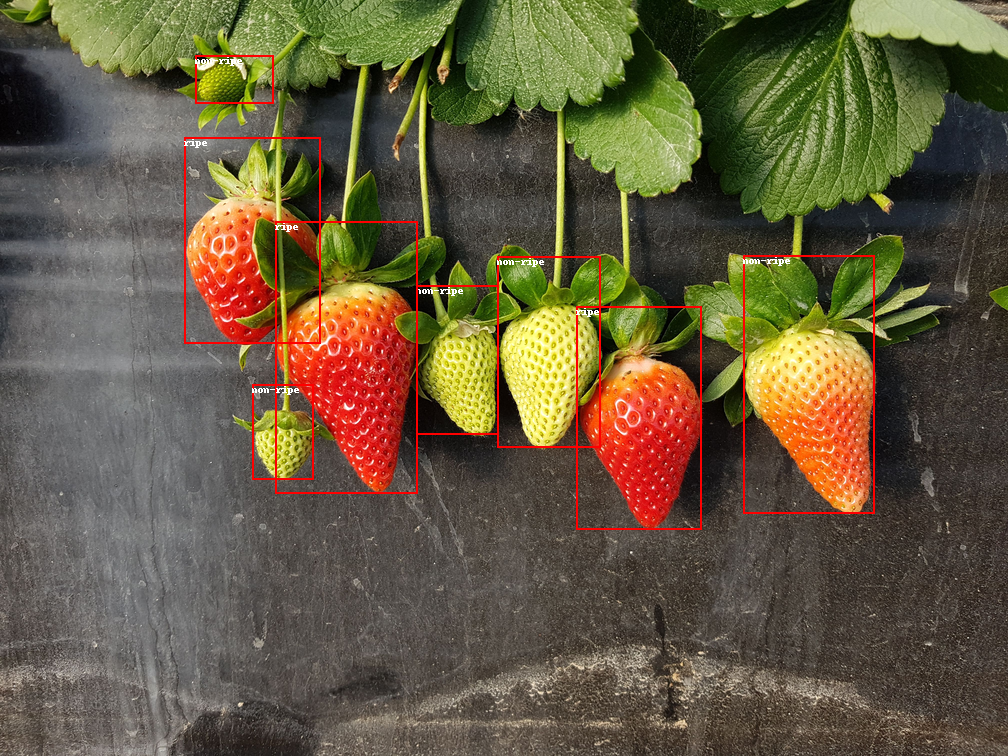

In [9]:
# Dmonstrate and image with GT bbox
image_idx = np.random.randint(0, len(sdb1['train']))

image = sdb1["train"][image_idx]["image"]
annotations = sdb1["train"][image_idx]['objects']
draw = ImageDraw.Draw(image)

# categories = {'0':'ripe', '1':'non-ripe'}
categories = ['ripe', 'non-ripe']

# prepare dictionaries of labels -> label ids and reverse
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

# show bbox annotations
for i in range(len(annotations['bbox'])):
    box = annotations["bbox"][i]
    class_idx = annotations["categories"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, w, h), outline="red", width=2)
    draw.text((x, y), id2label[class_idx], fill="white")

image

STEP 3: Create functions for transformations (or agumentations) like resize, normalise etc.

In [55]:
# prepare transforms for augmentations
import albumentations

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [56]:
# get resnet 50 backbone for image feature extraction
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [57]:
def formatted_anns(image_id, category, area, bbox) -> list:
    "returns input, labels in coco annotations format for train loop"
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [70]:
def transform_aug_ann(examples):
    """
    Analogus to dataloader but returns single data sample. 
    Attach this method to dataset transformers to retrieve train ready data
    * Uses transform func to perform augmentations
    * Uses formatted_anns func to get coco format targets
    * Uses image_processor to call cnn backbone
    Args:
        examples: dataset data points. call with datasets.with_transforms
    Returns:
        CNN backbone processed image and targets
    """
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        
        calc_bboxes = np.array(objects["bbox"], dtype=np.float32)
        
        # convert bboxes from [x_min, y_min, x_max, y_max] to [x_min, y_min, w, h]
        calc_bboxes[:, 2] = calc_bboxes[:, 2] - calc_bboxes[:, 0]
        calc_bboxes[:, 3] = calc_bboxes[:, 3] - calc_bboxes[:, 1]
        
        # correct negative annotations near x_min, y_min = 0
        calc_bboxes[calc_bboxes<0] = 0
        
        calc_areas = calc_bboxes[:, 2] * calc_bboxes[:, 3]
        
        # perform the transformations
        out = transform(image=image, bboxes=calc_bboxes, category=objects["categories"])
        
        area.append(torch.tensor(calc_areas, dtype=torch.float32))
        images.append(torch.tensor(out["image"], dtype=torch.float32))
        bboxes.append(torch.tensor(out["bboxes"], dtype=torch.float32))
        categories.append(torch.tensor(out["category"]))

    # prepare targets in coco format
    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    # process images with cnn backbone
    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [61]:
# Attach transformations to train dataset
sdb1['train'] = sdb1['train'].with_transform(transform_aug_ann)
sdb1['train'][0]

{'pixel_values': tensor([[[ 0.9132,  0.7419,  0.5022,  ..., -1.5357, -1.5357, -1.5357],
          [ 0.9646,  0.7591,  0.4851,  ..., -1.5699, -1.5699, -1.5870],
          [ 1.0331,  0.7933,  0.4508,  ..., -1.6042, -1.6384, -1.6727],
          ...,
          [-1.5870, -1.7925, -2.1008,  ..., -1.3644, -1.3987, -1.4158],
          [-1.5528, -1.6555, -1.8097,  ..., -1.2788, -1.3815, -1.4329],
          [-1.5357, -1.5699, -1.6042,  ..., -1.2274, -1.3644, -1.4500]],
 
         [[-0.3025, -0.4776, -0.7577,  ..., -1.2479, -1.2479, -1.2479],
          [-0.2325, -0.4426, -0.7577,  ..., -1.2829, -1.2829, -1.3004],
          [-0.1450, -0.3901, -0.7577,  ..., -1.3179, -1.3529, -1.3880],
          ...,
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -1.9832, -2.0007, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -1.9482, -1.9832, -2.0182]],
 
         [[ 0.5311,  0.3568,  0.0779,  ..., -0.8284, -0.8284, -0.8284],
          [ 

STEP 4: Create the train arguments and the train loop


In [64]:
from transformers import AutoModelForObjectDetection

# create transformer model
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
from transformers import TrainingArguments

# setup training hyperparameters
training_args = TrainingArguments(
    output_dir=TRAIN_CHECKPOINT_DIR,
    per_device_train_batch_size=4,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [63]:
def collate_fn(batch):
    "collate function to return batch dict"
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [12]:
from transformers import Trainer

# finally run the train loop with model, training args, dataset, collate_fn and backbone
torch.set_grad_enabled(True)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=sdb1["train"],
    tokenizer=image_processor,
)

trainer.train()

Using cuda_amp half precision backend
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2249
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 5630
  Number of trainable parameters = 41286663
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/home/bappadityadebnath/anaconda3/e

Step,Training Loss
50,2.167200
100,1.527500
150,1.385500
200,1.266200
250,1.273800
300,1.172200
350,1.159700
400,1.089300
450,1.116100
500,0.988900


Saving model checkpoint to detr-resnet-50_finetuned_sdb1/checkpoint-200
Configuration saved in detr-resnet-50_finetuned_sdb1/checkpoint-200/config.json
Model weights saved in detr-resnet-50_finetuned_sdb1/checkpoint-200/pytorch_model.bin
Image processor saved in detr-resnet-50_finetuned_sdb1/checkpoint-200/preprocessor_config.json
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50_finetuned_sdb1/checkpoint-400
Configuration saved in detr-resnet-50_finetuned_sdb1/checkpoin

Saving model checkpoint to detr-resnet-50_finetuned_sdb1/checkpoint-2000
Configuration saved in detr-resnet-50_finetuned_sdb1/checkpoint-2000/config.json
Model weights saved in detr-resnet-50_finetuned_sdb1/checkpoint-2000/pytorch_model.bin
Image processor saved in detr-resnet-50_finetuned_sdb1/checkpoint-2000/preprocessor_config.json
Deleting older checkpoint [detr-resnet-50_finetuned_sdb1/checkpoint-1600] due to args.save_total_limit
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to 

/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50_finetuned_sdb1/checkpoint-3800
Configuration saved in detr-resnet-50_finetuned_sdb1/checkpoint-3800/config.json
Model weights saved in detr-resnet-50_finetuned_sdb1/checkpoint-3800/pytorch_model.bin
Image processor saved in detr-resnet-50_finetuned_sdb1/checkpoint-3800/preprocessor_config.json
Deleting older checkpoint [detr-resnet-50_finetuned_sdb1/checkpoint-3400] due to args.save_total_limit
/home/bappadityadebnath/ana

Saving model checkpoint to detr-resnet-50_finetuned_sdb1/checkpoint-5400
Configuration saved in detr-resnet-50_finetuned_sdb1/checkpoint-5400/config.json
Model weights saved in detr-resnet-50_finetuned_sdb1/checkpoint-5400/pytorch_model.bin
Image processor saved in detr-resnet-50_finetuned_sdb1/checkpoint-5400/preprocessor_config.json
Deleting older checkpoint [detr-resnet-50_finetuned_sdb1/checkpoint-5000] due to args.save_total_limit
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/home/bappadityadebnath/anaconda3/envs/transformer/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to 

TrainOutput(global_step=5630, training_loss=0.7586498992269458, metrics={'train_runtime': 2497.108, 'train_samples_per_second': 9.006, 'train_steps_per_second': 2.255, 'total_flos': 1.074786736608e+19, 'train_loss': 0.7586498992269458, 'epoch': 10.0})

Step 5: Demonstrate a sample prediction

In [83]:
file_name = '../datasets/straw_db1/val/1029.png'

image = Image.open(file_name)

os.path.join 
image_processor = AutoImageProcessor.from_pretrained("../checkpoints/detr-resnet-50_finetuned_sdb1/checkpoint-5600/")
model = AutoModelForObjectDetection.from_pretrained("../checkpoints/detr-resnet-50_finetuned_sdb1/checkpoint-5600/")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected non-ripe with confidence 0.676 at location [683.64, 263.91, 737.0, 347.37]
Detected non-ripe with confidence 0.886 at location [737.57, 172.66, 890.71, 334.15]
Detected non-ripe with confidence 0.844 at location [574.15, 184.02, 698.6, 284.17]


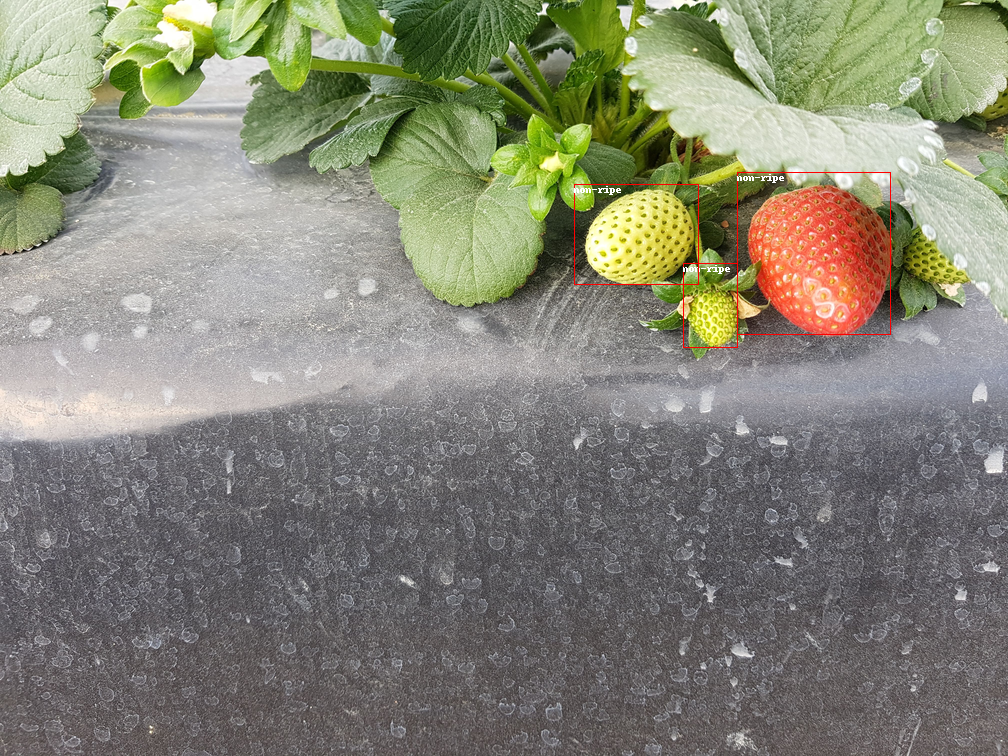

In [84]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image